# MLP Trial Plots

# make  x axis cleaner

/scratch/gilbreth/iyer95/conda_envs/plot/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/scratch/gilbreth/iyer95/conda_envs/plot/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/tmp/ipykernel_12260/146544971.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['Trial_bin'] = pd.cut(
/tmp/ipykernel_12260/146544971.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

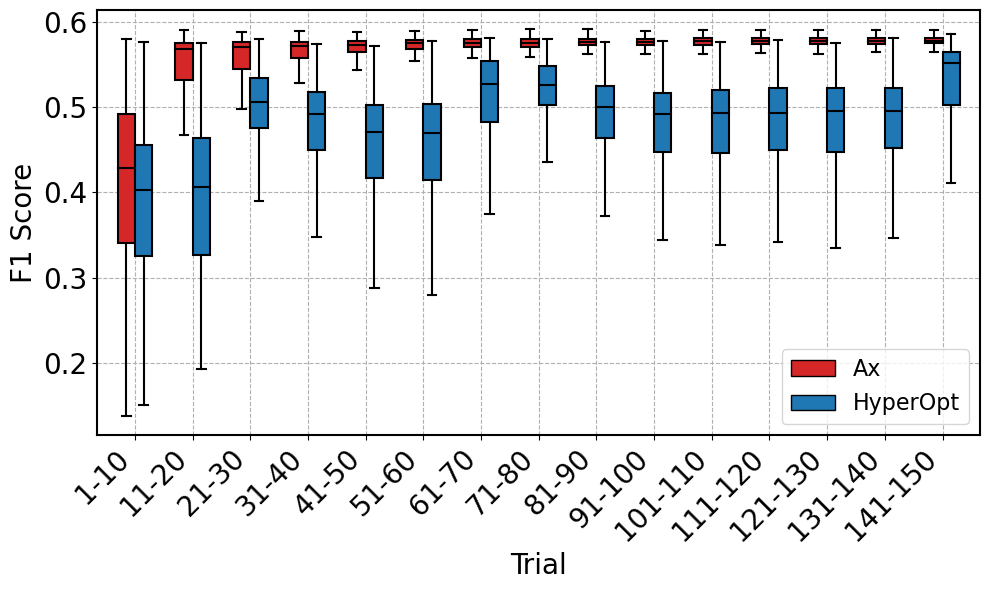

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch  # Import Patch for legend handles

# List of file paths
file_paths = [
    'mlp_AX_27Nov_Paper_150it_7496822_ALL_TRIALS.csv',
    'MLP_Hyperopt_10Jan25_7704199_TRIALS.csv',
    # 'mlp_RANDOM_26Nov_Paper_7494892_TRIAL.csv',
]

# Custom labels mapping: map full file path to label
custom_labels = {
    'mlp_AX_27Nov_Paper_150it_7496822_ALL_TRIALS.csv': 'Ax',
    'MLP_Hyperopt_10Jan25_7704199_TRIALS.csv': 'HyperOpt',
    # 'mlp_RANDOM_26Nov_Paper_7494892_TRIAL.csv': 'Random',
}

# Muted color scheme
color_scheme = {
    'Ax': '#D62728',        # Muted red
    'HyperOpt': '#1F77B4',  # Muted blue
    'Random': '#2CA02C',     # Green
}

# Initialize an empty list to hold DataFrames
df_list = []

for file_path in file_paths:
    # Read CSV
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"File {file_path} not found. Please check the path.")
        continue
    except pd.errors.EmptyDataError:
        print(f"File {file_path} is empty. Skipping.")
        continue
    except pd.errors.ParserError:
        print(f"File {file_path} is malformed. Skipping.")
        continue

    # Ensure required columns exist
    required_columns = {'Iteration', 'Trial', 'F1_Score'}
    if not required_columns.issubset(df.columns):
        print(f"File {file_path} is missing required columns. Skipping.")
        continue

    # Get the label from custom_labels
    label = custom_labels.get(file_path, 'Unknown')

    # Add 'File' column
    df['File'] = label

    # Append to list
    df_list.append(df)

# Check if any data was loaded
if not df_list:
    raise ValueError("No data loaded. Please check your file paths and file contents.")

# Concatenate all DataFrames
combined_df = pd.concat(df_list, ignore_index=True)

# Convert Trial to integer for binning
combined_df['Trial'] = combined_df['Trial'].astype(int)

# Select trials up to 150
subset_trials = list(range(1, 151))  # Trials 1 to 150 as integers
subset_df = combined_df[combined_df['Trial'].isin(subset_trials)]

# Verify that subset_df is not empty
if subset_df.empty:
    raise ValueError("No data found for trials 1 to 150. Please check your data.")

# Define bin size
bin_size = 10

# Create bin labels
bins = np.arange(0, 151, bin_size)  # [0, 10, 20, ..., 150]
labels = [f"{i+1}-{i+bin_size}" for i in bins[:-1]]  # ['1-10', '11-20', ..., '141-150']

# Assign trials to bins
subset_df['Trial_bin'] = pd.cut(
    subset_df['Trial'],
    bins=bins,
    labels=labels,
    right=True,  # Include the right edge in the bin
    include_lowest=True
)

# Ensure 'Trial_bin' is treated as a categorical variable with the correct order
subset_df['Trial_bin'] = subset_df['Trial_bin'].astype('category')

# Set the plot size
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplots
unique_files = subset_df['File'].unique()
num_algorithms = len(unique_files)
width = 0.6 / num_algorithms  # Adjust width based on number of algorithms
offset = -0.3 + width / 2  # Center the boxes around each bin

for idx, file_label in enumerate(unique_files):
    data = subset_df[subset_df['File'] == file_label]
    data_per_bin = [data[data['Trial_bin'] == bin]['F1_Score'] for bin in labels]
    positions = np.arange(len(labels)) + offset + idx * width

    bp = ax.boxplot(
        data_per_bin,
        positions=positions,
        patch_artist=True,
        widths=width,
        showfliers=False,  # Hide outliers for clarity
        boxprops=dict(linewidth=1.5, color='black'),
        whiskerprops=dict(linewidth=1.5, color='black'),
        capprops=dict(linewidth=1.5, color='black'),
        medianprops=dict(linewidth=1.5, color='black'),
    )

    # Set the box face color based on the color scheme
    for box in bp['boxes']:
        box.set_facecolor(color_scheme.get(file_label, '#7f7f7f'))  # Default to gray if not found
        box.set_edgecolor('black')  # Optional: Add border to boxes for better visibility

# Create custom legend handles using Patch
legend_handles = [
    Patch(facecolor=color_scheme.get(source, '#7f7f7f'), edgecolor='black', label=source)
    for source in unique_files
]
ax.legend(
    handles=legend_handles,
    title_fontsize=16,
    fontsize=16,
    loc='lower right',
    frameon=True  # Optional: Remove legend frame for a cleaner look
)

# Customize the plot
ax.set_xlabel('Trial', fontsize=20)
ax.set_ylabel('F1 Score', fontsize=20)

# Set x-axis ticks to be centered for each bin
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=20)

# Set y-axis labels
ax.tick_params(axis='y', labelsize=20)

# Add grid lines (both horizontal and vertical)
ax.grid(axis='both', linestyle='--', alpha=1.0)

# Customize spine properties
for spine_name, spine in ax.spines.items():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('MLP_BO_Trial_F1Score_norandom_A100_K.png', dpi=300, bbox_inches='tight')
plt.show()
